In [1]:
import  sys

#LOCALISATION DES DONNEES
sys.path.insert(0, "C:/projets_python/diabolo")

import warnings
warnings.filterwarnings("ignore")



#LIBRAIRIES PERSO
import etude_variable.MyLog as log
import etude_variable.jouer as jouer
import etude_variable.lecture_data as ld
import etude_variable.analyse as ana

# LIBRAIRIE PYHTON CLASSIQUES
import pandas as pd
import numpy as np
import matplotlib
import scipy
import platform

from collections import Counter

#ESTIMATEUR
import sklearn
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import  RandomForestClassifier
from sklearn import neighbors, datasets
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Imputer

from scipy.stats import uniform
from scipy.stats import randint

#TRAINING
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV
import dask_searchcv as dcv
from skopt.space import Real, Integer

#Evaluateur
from sklearn.model_selection import KFold

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

from sklearn.feature_selection import SelectFromModel


from evolutionary_search import EvolutionaryAlgorithmSearchCV
from sklearn.utils import class_weight

#outils
from dask.diagnostics import ProgressBar
import logging


#Metriques
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import learning_curve
from sklearn import  metrics
from sklearn.metrics import  roc_auc_score
from sklearn.metrics import  classification_report

#Outils

import time


#Graphique
from matplotlib import pyplot
from matplotlib import pyplot as plt
import seaborn as sns

print('Operating system version....', platform.platform())
print("Python version is........... %s.%s.%s" % sys.version_info[:3])
print('scikit-learn version is.....', sklearn.__version__)
print('pandas version is...........', pd.__version__)
print('numpy version is............', np.__version__)
print('matplotlib version is.......', matplotlib.__version__)
print('scipy version is.......', scipy.__version__)


Operating system version.... Windows-10-10.0.17134-SP0
Python version is........... 3.6.5
scikit-learn version is..... 0.19.1
pandas version is........... 0.22.0
numpy version is............ 1.14.2
matplotlib version is....... 2.2.0
scipy version is....... 1.0.0


In [2]:
def split_dataset(dataset, train_percentage, feature_headers,
                                  target_header,random_state=42,mode_debug=0):

    train_x, test_x, train_y, test_y = train_test_split(dataset[feature_headers], dataset[target_header],
                                                        train_size=train_percentage, test_size=None, random_state=42)


    if mode_debug==1:
        # Train and Test dataset size details
        print("--------------------------------")
        print("Train_x Shape :: ", train_x.shape)
        print("Train_y Shape :: ", train_y.shape)
        print("Test_x Shape :: ", test_x.shape)
        print("Test_y Shape :: ", test_y.shape)
        print("--------------------------------")

    return train_x, test_x, train_y, test_y


def construireFichierCSV(allure, best_model, feature_columns, response_column, mode_debug=0):
    # lecture des données a jouer


    xnames = ['ALLURE', 'CO_DISTANCE',
              'CO_PRIX', 'HIPPO',
              'IDCOURSE', 'IDPARTCIPANT',
              'PAR_AGE', 'PAR_ARRIVE',
              'PAR_CARRIERE',
              'PAR_CARRIERE_Q',
              'PAR_CLASSE_AGE',
              'PAR_COTEDER',
              'PAR_ENT_ECART_GAGNANT',
              'PAR_ENT_RAPPORT_GAGNANT_M',
              'PAR_ENT_REU_PLACE',
              'PAR_ENT_REUSSITE_GAGNE',
              'PAR_ENT_VICTOIRE',
              'PAR_GAIN',
              'pAR_JOC_ECART_GAGNANT',
              'PAR_JOC_ECART_PLACE',
              'PAR_JOC_NB_COURSE',
              'PAR_JOC_PLACE_3P',
              'pAR_JOC_RAPPORT_GAGNANT_M',
              'PAR_JOC_REU_PLACE',
              'pAR_JOC_REUSSITE_GAGNE',
              'pAR_JOC_VICTOIRE',
              'PAR_NP',
              'PAR_NUM',
              'PAR_PLACE',
              'PAR_PLACE_Q',
              'PAR_REUSSITE_3P',
              'PAR_REUSSITE_GAGNE',
              'PAR_REUSSITE_QUINTE',
              'PAR_RUESSITE_PLACE',
              'autostart',
              'cendre',
              'grande_piste',
              'Point',
              'Nb_partant', 'PAR_PROPRIO',
              'NOM_JOC',
              'NOM_ENTR',
              'POIDS',
              'CORDE',
              'CHEVAL','MUSIC_CHEVAL', 'MUSIC_ENT',
              'MUSIC_JOC',
              'PAR_VALEUR',
              'FIN_ligne']



    df_numero_a_predire = ld.lecture_data('d:\data_jour.csv', xnames, ['IDPARTCIPANT', 'IDCOURSE'],allure=allure,avec_index=True)
    df_numero_a_predire = df_numero_a_predire.groupby("ALLURE")
    df_numero_a_predire = df_numero_a_predire.get_group(allure)
    df_numero_a_predire = ld.my_drop(df_numero_a_predire, 'ALLURE')
    df_numero_a_predire = ld.my_drop(df_numero_a_predire, 'PAR_ARRIVE')
    df_numero_a_predire['SELECTION'] = 0


    train_x, test_x, train_y, test_y = split_dataset(df_numero_a_predire, 0, feature_columns, response_column)
    test_y = test_y['SELECTION'].ravel()

    # sauvegarde
    y_pred = best_model.predict(test_x)
    df_pred = pd.DataFrame.from_dict(y_pred)
    test_copy = test_x.copy()
    
    # UTILISATION DE BEST_MODEL
    PROBA = best_model.predict_proba(test_x)
    #print("PROBA \n %s" ,PROBA)

    df_proba = pd.DataFrame.from_dict(PROBA)
    #print(   df_proba)

    #print("df final=")
    df_final = pd.concat([df_proba, df_pred], axis=1)
    print(df_final.head(5))

    test_x = test_copy.copy()
    test_x = ld.my_drop(test_x, 'PAR_CLASSE_AGE')
    test_x = ld.my_drop(test_x, 'PAR_ENT_ECART_GAGNANT')
    test_x = ld.my_drop(test_x, 'PAR_ENT_RAPPORT_GAGNANT_M')
    test_x = ld.my_drop(test_x, 'PAR_ENT_REU_PLACE')
    test_x = ld.my_drop(test_x, 'PAR_ENT_REUSSITE_GAGNE')
    test_x = ld.my_drop(test_x, 'PAR_ENT_VICTOIRE')
    test_x = ld.my_drop(test_x, 'PAR_GAIN')
    test_x = ld.my_drop(test_x, 'pAR_JOC_ECART_GAGNANT')
    test_x = ld.my_drop(test_x, 'PAR_JOC_ECART_PLACE')
    test_x = ld.my_drop(test_x, 'PAR_JOC_NB_COURSE')
    test_x = ld.my_drop(test_x, 'PAR_JOC_PLACE_3P')
    test_x = ld.my_drop(test_x, 'PAR_REUSSITE_GAGNE')
    test_x = ld.my_drop(test_x, 'PAR_REUSSITE_QUINTE')
    test_x = ld.my_drop(test_x, 'PAR_RUESSITE_PLACE')
    test_x = ld.my_drop(test_x, 'CO_PRIX')
    test_x = ld.my_drop(test_x, 'PAR_CARRIERE')
    test_x = ld.my_drop(test_x, 'PAR_CARRIERE_Q')
    test_x = ld.my_drop(test_x, 'pAR_JOC_RAPPORT_GAGNANT_M')
    test_x = ld.my_drop(test_x, 'pAR_JOC_REUSSITE_GAGNE')
    test_x = ld.my_drop(test_x, 'pAR_JOC_VICTOIRE')
    test_x = ld.my_drop(test_x, 'PAR_PLACE')
    test_x = ld.my_drop(test_x, 'PAR_PLACE_Q')
    test_x = ld.my_drop(test_x, 'PAR_CLASSE_AGE')
    test_x = ld.my_drop(test_x, 'pAR_JOC_VICTOIRE')
    test_x = ld.my_drop(test_x, 'PAR_REUSSITE_3P')
    test_x = ld.my_drop(test_x, 'PAR_JOC_REU_PLACE')
    test_x = ld.my_drop(test_x, 'PAR_NUM')
    test_x = ld.my_drop(test_x, 'PAR_COTEDER')
    test_x = ld.my_drop(test_x, 'CORDE')
    test_x = ld.my_drop(test_x, 'musique')
    test_x = ld.my_drop(test_x, 'CHEVAL')
    test_x = ld.my_drop(test_x, 'Nb_partant')

    test_x = ld.my_drop(test_x, 'autostart')
    test_x = ld.my_drop(test_x, 'grande_piste')
    test_x = ld.my_drop(test_x, 'cendre')

    test_x = ld.my_drop(test_x, 'PAR_PROPRIO')
    test_x = ld.my_drop(test_x, 'NOM_JOC')
    test_x = ld.my_drop(test_x, 'NOM_ENTR')

    test_x = ld.my_drop(test_x, 'HIPPO')
    test_x = ld.my_drop(test_x, 'PAR_AGE')
    test_x = ld.my_drop(test_x, 'POIDS')
    test_x = ld.my_drop(test_x, 'CO_DISTANCE')
    test_x = ld.my_drop(test_x, 'CO_PRIX')
    test_x = ld.my_drop(test_x, 'PAR_GAIN_NORMA')
    test_x = ld.my_drop(test_x, 'CHEVAL2')
    test_x = ld.my_drop(test_x, 'PAR_REUSSITE_3P2')
    test_x = ld.my_drop(test_x, 'PAR_REUSSITE_QUINTE2')
    test_x = ld.my_drop(test_x, 'PAR_CLASSE_AGE2')
    test_x = ld.my_drop(test_x, 'PAR_COTEDER2')

    test_x = ld.my_drop(test_x, 'MUSIC_CHEVAL')
    test_x = ld.my_drop(test_x, 'MUSIC_ENT')
    test_x = ld.my_drop(test_x, 'MUSIC_JOC')
    test_x = ld.my_drop(test_x, 'PAR_VALEUR')

    test_x['v0'] = 0.0
    test_x['v1'] = 0.0
    test_x['sel'] = 0

    print("\n\nTest_x", test_x.head(4))

    # test_x
    cumul = 1
    nb_rows = len(df_proba.index)
    #rint("nb_rows=", nb_rows)

    for i in range(0, nb_rows):
        n = df_proba[0][i]
        test_x['v0'][i] = n

        n = df_proba[1][i]
        test_x['v1'][i] = n


    if (allure == 1):
        test_x.to_csv("d:\py_resultat_trot.csv")

    if (allure == 2):
        test_x.to_csv("d:\py_resultat_galop.csv")

    if (allure == 3):
        test_x.to_csv("d:\py_resultat_trot_monte.csv")

    if (allure == 4):
        test_x.to_csv("d:\py_resultat_haie.csv")

    if (allure == 5):
        test_x.to_csv("d:\py_resultat_steeple.csv")


    print("\n\n ALLER DANS APPLICATION DIABOLO ...Allure %s" % allure)


In [3]:
def explo_variable(dataset, svariable):

     # On calcule le quantile 0,25 qui est le quartile Q1
    mediane = np.median(dataset)
    print ("La mediane              "+svariable+"    : ", round(mediane, 2))

    maxx = np.max(dataset)
    print ("Le max              "+svariable+"    : ", round(maxx, 2))
    
    minn = np.min(dataset)
    print ("Le min              "+svariable+"    : ", round(minn, 2))
    
    
    moy = np.mean(dataset)
    print ("La moyenne               "+svariable+"   : ", round(moy, 2))

    variance = np.var(dataset)
    print ("La variance est          "+svariable+"   : ", round(variance, 2))
    
    ecartType = np.std(dataset)
    print ("Le ecart type            "+svariable+"   : ", round(ecartType, 2))
     
    print("")      
    
   # print(dataset.describe())
    
    print("")    
    

    
def CorrectionDesequilibre(train_x,train_y,feature_columns):

    from imblearn.combine import SMOTEENN
    from imblearn.over_sampling import SMOTE
    #from imblearn.under_sampling import TomekLinks
    #f"rom imblearn.under_sampling import RandomUnderSampler
    #from imblearn.under_sampling import AllKNN


    print('\nOriginal dataset shape {}'.format(Counter(train_y)))
    #sm = SMOTEENN(ratio='minority',n_jobs=4, random_state=42,smote=SMOTE(),n_neighbors=5)
    sm = SMOTE(ratio='auto', n_jobs=3, random_state=42,k_neighbors=50)
    X_res, y_res = sm.fit_sample(train_x, train_y)
    print('\nResampled dataset shape {}'.format(Counter(y_res)))
    # reconstitution DATAFRAME
    train_x = pd.DataFrame(X_res, columns=feature_columns)
    train_y = pd.Series(y_res)
    return train_x,train_y

In [4]:
def my_fit(estimateur, test_x,test_y, train_x, train_y, verbose=False):
    nb_split=80

    

    # Correction du desequiilibre
    #train_x, train_y = smot2(train_x=train_x, train_y=train_y, feature_columns=featurecolums)
    #test_x, test_y = smot2(train_x=test_x, train_y=test_y, feature_columns=featurecolums)


    log.traceLogInfo("\nTEST DU FIT ......DIRECT")
    #kfold = StratifiedKFold(n_splits=nb_split, shuffle=False, random_state=None)
    
    model=estimateur
    
    eval_set = [(train_x, train_y), (test_x, test_y)]
    model.fit(train_x, train_y, eval_metric=["error", "auc"], eval_set=eval_set, verbose=verbose, early_stopping_rounds=10)
    y_pred = model.predict(test_x)
    predictions = [round(value) for value in y_pred]

    
    return model,y_pred,predictions



def my_fit2(estimateur, train_x, train_y):
    kfold = StratifiedKFold(n_splits=2, random_state=None, shuffle=False)
    
    results = cross_val_score(estimateur, train_x, train_y, cv=kfold)
    print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
    
    y_pred = model.predict(test_x)
    predictions = [round(value) for value in y_pred]
    return model,y_pred,predictions


    
    


def fit_special(estimateur,    test_x,test_y, train_x, train_y):



    # Use SelectFromModel
    thresholds = np.sort(estimateur.best_estimator_.named_steps["clf"].feature_importances_)

    for thresh in thresholds:
        # select features using threshold
        selection = SelectFromModel(estimateur, threshold=thresh, prefit=True)
        select_X_train = selection.transform(train_x)

        # train model
        selection_model = estimateur
        selection_model.fit(select_X_train, train_y)

        # eval model
        select_X_test = selection.transform(test_x)
        y_pred = selection_model.predict(select_X_test)
        predictions = [round(value) for value in y_pred]
        accuracy = accuracy_score(test_y, predictions)
        print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy * 100.0))
        print(confusion_matrix(test_y, predictions))
        print(classification_report(test_y, predictions))

    y_pred = estimateur.predict(test_x)
    predictions = [round(value) for value in y_pred]
    return estimateur,y_pred,predictions


In [5]:
def afficheEvalSet(mybest_model,
                    set_train,
                   set_train_cible,
                   set_test,
                   set_test_cible,
                   mode_debug=0,
                   type_eval=1):

    print("\nEVAL SET ....")

    set_test_cible_predicted = mybest_model.predict(set_test)
    set_train_cible_predicted = mybest_model.predict(set_train)

    if type_eval==1:
                print("Evaluation TEST-----------------------------------------------------------------------")
                set_test_cible_probabilities = mybest_model.predict_proba(set_test)
                score = set_test_cible_probabilities[:, 1]
                auc = roc_auc_score(set_test_cible, set_test_cible_predicted)
                print("TEST roc_auc_score :  %s" % auc)
    else:
                set_train_cible_probabilities = mybest_model.predict_proba(set_train)
                auc = roc_auc_score(set_train_cible, set_train_cible_predicted)
                print("TRAINING roc_auc_score :  %s" % auc)
    
    for x, y in [(set_train, set_train_cible), (set_test, set_test_cible)]:
            yp = mybest_model.predict(x)
            cm = confusion_matrix(y, yp.ravel())
            print(cm)

    import matplotlib.pyplot as plt

    
    
    plt.matshow(cm)
    plt.title('Confusion matrix')
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    if type_eval==1:
        ntotal = len(set_test)
        correct = set_test_cible == set_test_cible_predicted
        numCorrect = sum(correct)
        percent = round((100.0 * numCorrect) / ntotal, 3)

        log.traceLogInfo("Classification Correcte des données de test : {0:d}/{1:d}  {2:8.3f}%".format(numCorrect, ntotal, percent))

        prediction_score = 100.0 * mybest_model.score(set_test, set_test_cible)
        log.traceLogInfo('\nScore  TEST  : %8.3f  ************************' % prediction_score)
    else:
        ntotal = len(set_train)
        correct = set_train_cible== set_train_cible_predicted
        numCorrect = sum(correct)
        percent = round((100.0 * numCorrect) / ntotal, 3)

        log.traceLogInfo("\n CLASSIFICATION CORRECTE DES DONNEES DE Train  : {0:d}/{1:d}  {2:8.3f}%".format(numCorrect, ntotal, percent))

        prediction_score = 100.0 * mybest_model.score(set_train, set_train_cible)
        log.traceLogInfo('Score  TRAINING  : %8.3f  ************************' % prediction_score)



# RECHERCHE

In [6]:
  # ICI ON FAIT UNE RECHERCHE DES BON PARAMTRE
def recherche_fit_BayesSearchCV(): 
    model =XGBClassifier(base_score=0.5,
                  booster='gbtree',
                colsample_bylevel=0.6,
                colsample_bytree=0.8,
                 gamma=0.01,
                 learning_rate=0.07, #ok
                max_delta_step=3, #ok
                max_depth=6, #ok
                max_features='sqrt',
                min_child_weight=8, #ok
                n_estimators=1900,#ok
                n_jobs=2,#ok
                nthread=None,
                objective='binary:logistic',
                 random_state=10,
                reg_alpha=0.1, #ok
                reg_lambda=2.5,
                scale_pos_weight=1,
                 seed=800,
                subsample=0.99,
                silent=False
                )
    
    kfold = StratifiedKFold(n_splits=20, shuffle=True, random_state=42)
    
    print("definition de BayesSearchCV\n ")
    searchcv = BayesSearchCV( model,refit=True, n_jobs=2, scoring="roc_auc",cv=kfold,
                    search_spaces=[

                    
                        ({'n_estimators': Integer(1000, 5000)}, 10),
                        
                 #      ({'max_delta_step': Integer(0, 12)},10),
                    #    (      {'seed': Integer(25, 999)},1)
                        #({'random_state': Integer(5, 50)},5),
                           ( {'colsample_bylevel': Real(2e-1, 1, 'log-uniform')},5),
                           ({'gamma': Real(0.09e-1, 1.20e-1, 'log-uniform')},5),
                           ({'colsample_bytree': Real(1e-1, 7e-1, 'log-uniform')}, 5),
                          #     ( {'learning_rate': Real(0.1e-2,1, 'log-uniform')},10),

                        ], n_iter=200, return_train_score=False,verbose=5
                    )

    
    
    def on_step(optim_result):
        score = searchcv.best_score_
        log.traceLogInfo("best score: %s" % score)
        log.traceLogInfo("Params : %s" % searchcv.best_params_)
        log.traceLogInfo("iteration : %s" % searchcv.total_iterations)
                        #log.traceLogInfo("Params : %s" % searchcv.get_params())
        if score >= 0.99:
                            print('Interrupting!')
                            return True
                        

    print("\nFit AVEC SEARCH ....")
    searchcv.fit(X=train_x, y=train_y, callback=on_step)
    res=pd.DataFrame(searchcv.cv_results_)
    
    print("Test score :",searchcv.score(test_x, test_y))
    print("")
    
    print("\nDonnées bloquées :",searchcv.scorer_)
    print("Nombre de divisions de validation croisée :", searchcv.n_splits_)
    
    res = res.sort_values(by=['mean_test_score'], ascending=False, axis=0)
    res.reset_index(inplace=True, drop=True)
    a = res[['mean_test_score', 'std_test_score']]

    res.drop(['mean_test_score', 'std_test_score', 'params', 'mean_fit_time', 'mean_score_time', 'std_fit_time', 'std_score_time'], axis=1, inplace=True)
    res = pd.concat([a, res], axis=1)

    print("best_score_: {:.4f}\nbest_params_: {}".format(searchcv.best_score_, searchcv.best_params_))
    print("\nTest train :", searchcv.score(train_x,train_y))
    print("\n TOTAL ITERATION : %s" % searchcv.total_iterations)

    print(res.head(5))
                    # SAUVEGARDE DU MODELE
     #                   ld.save_mymodel(clf=searchcv, allure=allure)

                    #  ld.save_mymodel(clf=gsearch, allure=allure)
    
    y_pred = searchcv.predict(test_x)
    predictions = [round(value) for value in y_pred]
    return searchcv,y_pred,predictions


In [7]:
def recherche_random_XGBClassifier( model, x_train, y_train,x_test,y_test,param_grid, nb_iter):
    clf = model

    
    fit_params = {'eval_metric': 'auc',
              'early_stopping_rounds': 10,
              'eval_set': [(x_test, y_test)]}
    
    rs_clf = RandomizedSearchCV(clf, param_grid, n_iter=nb_iter,
                            n_jobs=2, verbose=3, cv=10,
                            fit_params=fit_params,
                            scoring='neg_log_loss', refit=True, random_state=42)
    print("Randomized search..")
    search_time_start = time.time()
    rs_clf.fit(x_train, y_train)
    print("Randomized search time:", time.time() - search_time_start)
    best_score = rs_clf.best_score_
    best_params = rs_clf.best_params_
    
    print("Best score: {}".format(best_score))
    print("Best params: ")
    
    for param_name in sorted(best_params.keys()):
       print('%s: %r' % (param_name, best_params[param_name]))



    y_pred = rs_clf.predict(x_test)
    predictions = [round(value) for value in y_pred]
    
    return rs_clf.best_estimator_,y_pred,predictions
    
    
    

In [8]:
def plot_importance(feature_columns, model):
    importances = pd.DataFrame({'feature': feature_columns, 'importance': np.round(model.feature_importances_, 3)})
    importances = importances.sort_values('importance', ascending=False).set_index('feature')
    print("")
    print( importances)
    importances.plot.bar()

def plot_2(model,cr1="auc",cr2="error"):
    
        # retrieve performance metrics
        results = model.evals_result()
        epochs = len(results['validation_0'][cr1])
        x_axis = range(0, epochs)

        # plot log loss
        fig, ax = pyplot.subplots()
        ax.plot(x_axis, results['validation_0'][cr2], label='Train')
        ax.plot(x_axis, results['validation_1'][cr2], label='Test')
        ax.legend()
        pyplot.ylabel('auc')
        pyplot.title('XGBoost Error')
        pyplot.show()

        # plot classification error
        fig, ax = pyplot.subplots()
        ax.plot(x_axis, results['validation_0'][cr1], label='Train')
        ax.plot(x_axis, results['validation_1'][cr1], label='Test')
        ax.legend()
        pyplot.ylabel('Classification Auc')
        pyplot.title('XGBoost Classification Auc')
        pyplot.show()
    
    
    
def evaluation_1(test_y, predictions,featurecolums, model):
    print(classification_report(test_y, predictions))
    plot_importance(feature_columns=featurecolums,model=model)
    from sklearn.feature_selection import SelectKBest
    from sklearn.feature_selection import chi2
    names = feature_columns
    print("----------KBEST-----------------")
    
    for n in range(0, len(names)):
        test = SelectKBest(score_func=chi2, k=9)
        fit = test.fit(train_x, train_y)
        print(names[n],'   ', fit.scores_[n])
    

    print("--------------------------")
    
def evaluation_2(model, train_x, train_y, test_x, test_y):    
    from sklearn.feature_selection import RFE
    rfc=model
    # create the RFE model and select 4 attributes
    rfe_model = RFE(rfc, 9, step=1)
    rfe_model = rfe_model.fit(train_x, train_y)
    # summarize the selection of the attributes
    print(rfe_model.support_)
    print(rfe_model.ranking_)

    # evaluate the model on testing set
    pred_y = rfe_model.predict(test_x)
    predictions = [round(value) for value in pred_y]
    accuracy = accuracy_score(test_y, predictions)
    print("Test Accuracy: %.2f%%" % (accuracy*100.0))
    print(train_x.mean()   )
    
    
def metrique_classe(y_pred,y_true,xclass):
    from imblearn.metrics import specificity_score
    from imblearn.metrics import geometric_mean_score

    #log.traceLogInfo("Classe ", xclass)
    log.traceLogInfo("Sensibilité  du reequilibrage des données sur le TEST")
    log.traceLogInfo("La spécificité est intuitivement la capacité du classificateur à trouver tous les échantillons positifs")
    log.traceLogInfo(specificity_score(y_true, y_pred, labels=None, pos_label=xclass, average='binary', sample_weight=None))
    print("\nCalculer la moyenne géométrique")
    print(geometric_mean_score(y_true, y_pred,labels=None, pos_label=xclass))


# CHAMPS et INDEX

In [9]:
xnames = ['ALLURE', 'CO_DISTANCE',
              'CO_PRIX', 'HIPPO',
              'IDCOURSE', 'IDPARTCIPANT',
              'PAR_AGE', 'PAR_ARRIVE',
              'PAR_CARRIERE',
              'PAR_CARRIERE_Q',
              'PAR_CLASSE_AGE',
              'PAR_COTEDER',
              'PAR_ENT_ECART_GAGNANT',
              'PAR_ENT_RAPPORT_GAGNANT_M',
              'PAR_ENT_REU_PLACE',
              'PAR_ENT_REUSSITE_GAGNE',
              'PAR_ENT_VICTOIRE',
              'PAR_GAIN',
              'pAR_JOC_ECART_GAGNANT',
              'PAR_JOC_ECART_PLACE',
              'PAR_JOC_NB_COURSE',
              'PAR_JOC_PLACE_3P',
              'pAR_JOC_RAPPORT_GAGNANT_M',
              'PAR_JOC_REU_PLACE',
              'pAR_JOC_REUSSITE_GAGNE',
              'pAR_JOC_VICTOIRE',
              'PAR_NP',
              'PAR_NUM',
              'PAR_PLACE',
              'PAR_PLACE_Q',
              'PAR_REUSSITE_3P',
              'PAR_REUSSITE_GAGNE',
              'PAR_REUSSITE_QUINTE',
              'PAR_RUESSITE_PLACE',
              'autostart',
              'cendre',
              'grande_piste',
              'Point',
              'Nb_partant', 'PAR_PROPRIO',
              'NOM_JOC',
              'NOM_ENTR',
              'POIDS',
              'CORDE', 'CHEVAL', 'MUSIC_CHEVAL',
              'MUSIC_ENT',
              'MUSIC_JOC',
              'PAR_VALEUR',
              'FIN_ligne']

index_col = ['IDPARTCIPANT', 'IDCOURSE']


def assign_selection(W):
    if W < 5:
        return 1
    else:
        return 0
    
    # Creating bins for the win column
def assign_selection2(W):
    if W == 1.0:
        return 1
    if W == 0.0:
        return 0



# LECTURE DES DONNEES

In [10]:
allure_etudier=1

In [11]:
  # Lecture des données sans index
df = ld.lecture_data('d:\data_diabolo.csv', xnames, xindex_col=index_col, allure=allure_etudier, avec_index=False)
print(df.info())
    



Lecture data d:\data_diabolo.csv
Fin de lecture  de d:\data_diabolo.csv
head10
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539600 entries, 0 to 539599
Data columns (total 35 columns):
ALLURE                       539600 non-null int64
CO_PRIX                      539600 non-null int64
HIPPO                        539600 non-null int64
IDCOURSE                     539600 non-null int64
IDPARTCIPANT                 539600 non-null int64
PAR_AGE                      539600 non-null int64
PAR_ARRIVE                   539600 non-null int64
PAR_CARRIERE                 539600 non-null int64
PAR_CARRIERE_Q               539600 non-null int64
PAR_ENT_ECART_GAGNANT        539600 non-null int64
PAR_ENT_RAPPORT_GAGNANT_M    539600 non-null float64
PAR_ENT_REU_PLACE            539600 non-null float64
PAR_ENT_REUSSITE_GAGNE       539600 non-null float64
PAR_ENT_VICTOIRE             539600 non-null int64
pAR_JOC_ECART_GAGNANT        539600 non-null int64
PAR_JOC_ECART_PLACE          539600 non

In [12]:
explo_variable(df['PAR_REUSSITE_3P'],"PAR_REUSSITE_3P")

La mediane              PAR_REUSSITE_3P    :  0.27
Le max              PAR_REUSSITE_3P    :  1.0
Le min              PAR_REUSSITE_3P    :  0.0
La moyenne               PAR_REUSSITE_3P   :  0.29
La variance est          PAR_REUSSITE_3P   :  0.03
Le ecart type            PAR_REUSSITE_3P   :  0.18




# Filtre des données  :  Allure 

In [13]:

#Filtre des données¶
df2=df[df.Point>0]
    #df = df[df.PAR_COTEDER > 0]
df2 = df2[df2.PAR_ARRIVE > 0]  # On garde la ligne qui possede information arrivée

df2 = df2.groupby("ALLURE")
df2 = df2.get_group(allure_etudier)
df2 = ld.my_drop(df2, 'ALLURE')

if allure_etudier == 2 or allure_etudier == 4 or allure_etudier == 5:
    df2 = df2[df2.POIDS > 0]
    df2 = df2[df2.POIDS < 80]
#  on a lu les données avant l 'ajout de la colonne SELECTIOB
df2['SELECTION2'] = df2['PAR_ARRIVE'].apply(assign_selection)

df2.drop(["PAR_ARRIVE"], axis=1, inplace=True)
print(df2.shape)

(276545, 34)


# Definition de la cible

In [14]:
Lib_features_df = df2.columns
xdata = df2.values
df_gagnant = pd.DataFrame(data=xdata, columns=Lib_features_df)

df_gagnant['SELECTION'] = df_gagnant['SELECTION2'].apply(assign_selection2)
df_gagnant.drop(["SELECTION2"], axis=1, inplace=True)
df_gagnant = df_gagnant.set_index(index_col)

df_gagnant_len = len(df_gagnant.columns) - 1
Lib_features = df_gagnant.columns[:df_gagnant_len]
feature_columns = Lib_features  ##<<<<<<<<<<<<<<<<
response_column = ['SELECTION']  ##<<<<<<<<<<<<<<<<
log.traceLogdebug("Features                   : %s " % Lib_features, " <<<<************")

print("(1) Shape df_gagnant  ", df_gagnant.shape,"\n")
print("(2) FEATURES ",Lib_features)
print("(3) response column ",response_column)
# df_gagnant, feature_columns, response_column, ratio SONT DEFINI


(1) Shape df_gagnant   (276545, 32) 

(2) FEATURES  Index(['CO_PRIX', 'HIPPO', 'PAR_AGE', 'PAR_CARRIERE', 'PAR_CARRIERE_Q',
       'PAR_ENT_ECART_GAGNANT', 'PAR_ENT_RAPPORT_GAGNANT_M',
       'PAR_ENT_REU_PLACE', 'PAR_ENT_REUSSITE_GAGNE', 'PAR_ENT_VICTOIRE',
       'pAR_JOC_ECART_GAGNANT', 'PAR_JOC_ECART_PLACE', 'PAR_JOC_NB_COURSE',
       'PAR_JOC_PLACE_3P', 'pAR_JOC_RAPPORT_GAGNANT_M', 'PAR_JOC_REU_PLACE',
       'pAR_JOC_REUSSITE_GAGNE', 'pAR_JOC_VICTOIRE', 'PAR_NUM', 'PAR_PLACE',
       'PAR_PLACE_Q', 'PAR_REUSSITE_3P', 'PAR_REUSSITE_GAGNE',
       'PAR_REUSSITE_QUINTE', 'PAR_RUESSITE_PLACE', 'Point', 'Nb_partant',
       'PAR_PROPRIO', 'NOM_JOC', 'NOM_ENTR', 'CHEVAL'],
      dtype='object')
(3) response column  ['SELECTION']


# CORRELATION


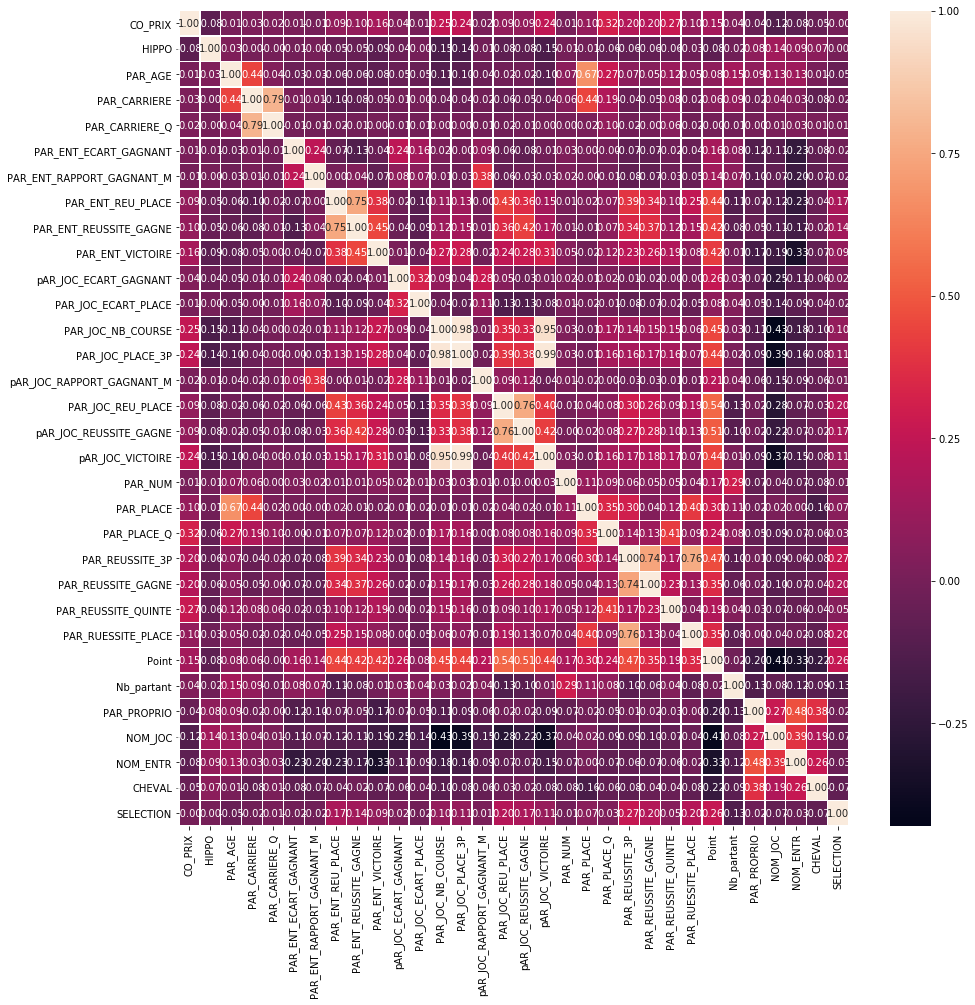

In [15]:
#Enfin, quelque chose de vraiment cool que vous pouvez mettre 

#dans une carte de chaleur est une matrice de corrélation. 
#Pandas DataFrame a une méthode corr qui calcule le coefficient de corrélation de Pearson (peut être un autre)
#entre tous les couples de colonnes numériques du DataFrame.

fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(df_gagnant.corr(), annot=True, fmt=".2f", linewidths=.4, ax=ax)


Proportion: 2.42 : 1
Total number of records : 276545 
Nombre de participations avec SELECTION = 0 : 195698
Nombre de participations avec SELECTION = 1  : 80847
Pourcentage 0: 70.7653%,  pourcentage 1 : 29.2347%


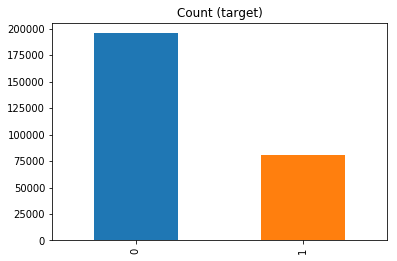

In [16]:
target_count = df_gagnant['SELECTION'].value_counts()


print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')
target_count.plot(kind='bar', title='Count (target)')

normal_trans_perc = sum(df_gagnant['SELECTION'] == 0) / (sum(df_gagnant['SELECTION'] == 0) + sum(df_gagnant['SELECTION'] == 1))
fraud_trans_perc = 1 - normal_trans_perc
print('Total number of records : {} '.format(len(df_gagnant)))
print('Nombre de participations avec SELECTION = 0 : {}'.format(sum(df_gagnant['SELECTION'] == 0)))
print('Nombre de participations avec SELECTION = 1  : {}'.format(sum(df_gagnant['SELECTION'] == 1)))
print('Pourcentage 0: {:.4f}%,  pourcentage 1 : {:.4f}%'.format(normal_trans_perc * 100,fraud_trans_perc * 100))




# Definition des set

In [17]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(df_gagnant[feature_columns],
                                                     df_gagnant[response_column], test_size=0.33, random_state=42)
train_eval_X =  df_gagnant[feature_columns]
train_eval_Y=  df_gagnant[response_column]





print("Train_x",train_x.shape)
print("Train y",train_y.shape)
print("Test x",test_x.shape)
print("Test y",test_y.shape)

print("train_eval_X",train_eval_X.shape)
print("train_eval_Y",train_eval_Y.shape)

print("Test x",test_x.shape)
print("Test y",test_y.shape)

test_y = test_y['SELECTION'].ravel()
train_y = train_y['SELECTION'].ravel()



Train_x (185285, 31)
Train y (185285, 1)
Test x (91260, 31)
Test y (91260, 1)
train_eval_X (276545, 31)
train_eval_Y (276545, 1)
Test x (91260, 31)
Test y (91260, 1)


In [18]:
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier,VotingClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.svm import SVC

In [19]:

clf2 = ExtraTreesClassifier(n_estimators=500, n_jobs=-1, criterion='gini',max_depth=5)
clf3 = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.6,
       colsample_bytree=1.0, gamma=1.0, learning_rate=0.012,
       max_delta_step=3, max_depth=8, max_features='sqrt',
       min_child_weight=0.5, missing=None, n_estimators=2000, n_jobs=3,
       nthread=None, objective='binary:logistic', random_state=42,
       reg_alpha=0.1, reg_lambda=5.0, scale_pos_weight=1, seed=900,
       silent=False, subsample=0.9)
clf4 = GradientBoostingClassifier(n_estimators=500)

clf1=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)



In [ ]:

eclf = VotingClassifier(estimators=[('svc', clf1), ('etc', clf2), ('xgb', clf3),('gbc', clf4)], weights=[1,1,5,1], voting='hard')
model = eclf.fit(train_x, train_y)

In [ ]:
print('Testing score: ', model.score(test_x, test_y))

In [ ]:
from sklearn.preprocessing import QuantileTransformer
from sklearn.pipeline import Pipeline
pipe = Pipeline([
        ('scaler', QuantileTransformer()),
        ('classi',XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.6,
       colsample_bytree=1.0, gamma=1.0, learning_rate=0.012,
       max_delta_step=3, max_depth=8, max_features='sqrt',
       min_child_weight=0.5, missing=None, n_estimators=2000, n_jobs=3,
       nthread=None, objective='binary:logistic', random_state=42,
       reg_alpha=0.1, reg_lambda=5.0, scale_pos_weight=1, seed=900,
       silent=False, subsample=0.9))
        ])

model=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.6,
       colsample_bytree=1.0, gamma=1.0, learning_rate=0.012,
       max_delta_step=3, max_depth=8, max_features='sqrt',
       min_child_weight=0.5, missing=None, n_estimators=2000, n_jobs=3,
       nthread=None, objective='binary:logistic', random_state=42,
       reg_alpha=0.1, reg_lambda=5.0, scale_pos_weight=1, seed=900,
       silent=False, subsample=0.9)


In [ ]:
pipe = pipe.fit(train_x, train_y)
print('Testing score: ', pipe.score(test_x, test_y))

In [ ]:
model = model.fit(train_x, train_y)
print('Testing score: ', model.score(test_x, test_y))

# ESTIMATEUR

In [ ]:
 #searchcv,y_pred,predictions=recherche_fit_BayesSearchCV()
model=XGBClassifier(base_score=0.5,
                  booster='gbtree',
                colsample_bylevel=0.2,
                colsample_bytree=0.8,
                 gamma=0.01,
                 learning_rate=0.06, #ok
                max_delta_step=3, #ok
                max_depth=8, #ok
               max_features='sqrt',
                min_child_weight=8, #ok
                n_estimators=1800,#ok
                n_jobs=3,#ok
                nthread=None,
                objective='binary:logistic',
                 random_state=42,
                reg_alpha=0.1, #ok
                reg_lambda=2.5,

                 seed=800,
                subsample=0.99,
                silent=False)

               
model=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.6,
       colsample_bytree=1.0, gamma=1.0, learning_rate=0.012,
       max_delta_step=3, max_depth=8, max_features='sqrt',
       min_child_weight=0.5, missing=None, n_estimators=1800, n_jobs=3,
       nthread=None, objective='binary:logistic', random_state=42,
       reg_alpha=0.1, reg_lambda=5.0, scale_pos_weight=1, seed=800,
       silent=False, subsample=0.9)
 
param_grid = {'silent': [False],
     #   'max_depth': [ 7, 8,9],
     #   'learning_rate': [0.009,0.01,0.011,0.012,0.18,0.02,0.03,0.04, 0.05],
     #   'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
     #   'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
     #   'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
     #   'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
     #   'gamma': [0, 0.25, 0.5, 1.0],
        'seed': [500, 600, 700, 800,900,1000],
     #   'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0]
        'n_estimators': [500,700,900,1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000,2100,2000]
              }       

searchcv,y_pred,predictions=recherche_random_XGBClassifier( model, train_x, train_y,test_x,test_y,param_grid,50)

print(searchcv)

model=searchcv

    

In [ ]:
#res=pd.DataFrame(searchcv.cv_results_)

print(searchcv)

model=searchcv

In [ ]:


eval_set = [(train_x, train_y), (test_x, test_y)]
model.fit(train_x, train_y, eval_metric=["error", "auc"], eval_set=eval_set, verbose=False, early_stopping_rounds=20)
y_pred = model.predict(test_x)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(test_y, predictions)
print("************************************************************  Accuracy: %.2f%%" % (accuracy * 100.0))


In [ ]:
ld.save_mymodel(model, allure_etudier)
#model = ld.load_mymodel(allure_etudier)

In [ ]:
evaluation_1(test_y, predictions,feature_columns, model)

#evaluation_2(model, train_x, train_y, test_x, test_y)    



In [ ]:
y_pred = model.predict(test_x)
metrique_classe(y_pred=y_pred, y_true=test_y, xclass=1)


In [ ]:
afficheEvalSet(model,train_x,train_y,test_x,test_y,type_eval=1)
afficheEvalSet(model,train_x,train_y,test_x,test_y,type_eval=2)

In [ ]:
afficheEvalSet(model,train_x,train_y,test_x,test_y,type_eval=2)

# CSV

In [ ]:
construireFichierCSV(1, model, feature_columns, response_column, 0)